# Midterm

## Options

In [18]:
train_SRGAN = True
continueTraining_SRGAN = True

## Imports

In [2]:
import numpy as np
from tensorflow import keras
import tensorflow as tf
import os
import datetime
import shutil
import re
import time
#from tqdm import tqdm

logs_base_dir = "./logs"
shutil.rmtree(logs_base_dir, ignore_errors=True)
os.makedirs(logs_base_dir, exist_ok=True)

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu,True)
    except RuntimeError as e:
        print(e)

%load_ext tensorboard

In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2426466275523281686
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6920601600
locality {
  bus_id: 1
  links {
  }
}
incarnation: 4824615202882768575
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1080, pci bus id: 0000:0a:00.0, compute capability: 6.1"
]


### Separating the data

In [10]:
label_list = []
cats = [0 for i in range(12500)]
dogs = [1 for i in range(12500)]
label_list.extend(cats)
label_list.extend(dogs)

In [11]:

ds = keras.utils.image_dataset_from_directory(
    directory='data/dogs_cats/train/',
    labels=label_list,
    label_mode=None,
    batch_size=64,
    image_size=(128,128),
    seed=0,
)
(train_ds) = ds

Found 25000 files belonging to 1 classes.


### Preprocess and Augment the data

In [4]:
data_augmentation = keras.Sequential(
    [
        keras.layers.RandomFlip("horizontal"),
        keras.layers.RandomRotation(0.1),
        keras.layers.RandomFlip("vertical"),
        keras.layers.RandomZoom(height_factor=0.1,width_factor=0.1)
    ]
)

## Step 2: Training SRGAN

In [5]:
def GENBlock(x):
    out = keras.layers.Conv2D(64, (3,3), (1,1), padding='same')(x)
    out = keras.layers.BatchNormalization()(out)
    out = keras.layers.PReLU()(out)
    out = keras.layers.Conv2D(64, (3,3), (1,1), padding='same')(x)
    out = keras.layers.BatchNormalization()(out)
    out = keras.layers.Add()([out, x])
    return out

def DISBlock(x, n):
    out = keras.layers.Conv2D(n, (3,3), (1,1), padding='same')(x)
    out = keras.layers.BatchNormalization()(out)
    out = keras.layers.LeakyReLU(0.2)(out)
    out = keras.layers.Conv2D(n, (3,3), (2,2), padding='same')(x)
    out = keras.layers.BatchNormalization()(out)
    out = keras.layers.LeakyReLU(0.2)(out)
    return out


### Helper Function

In [6]:
import matplotlib.pyplot as plt
from IPython import display

def generate_and_save_images(model, epoch, test_input, gt_output):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 3))

  for i in range(12):
      plt.subplot(4, 3, i+1)
      if i % 3 == 0:
         plt.imshow(tf.cast(tf.clip_by_value(predictions[i // 3, :, :, :], 0, 255), "uint8"))
      elif i % 3 == 1:
         plt.imshow(tf.cast(tf.clip_by_value(test_input[i // 3], 0, 255), "uint8")) 
      else:
         plt.imshow(tf.cast(tf.clip_by_value(gt_output[i // 3], 0, 255), "uint8"))
      
      if i == 0:
         plt.title("Generated")
      elif i == 1:
         plt.title("Resized")
      elif i == 2:
         plt.title("Original")
      plt.axis('off')

  plt.savefig('training_outputs/image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()
  plt.close()

### Generator 64x64 to 128x128

In [9]:
inputs = keras.Input(shape=(64,64,3))
scaled_layer = keras.layers.Rescaling(scale=1/255.0, offset=0)

x = scaled_layer(inputs)
x = keras.layers.Conv2D(64, (9,9), (1,1), padding='same')(x)
x = keras.layers.PReLU()(x)
x_skip = x
for i in range(5):
    x = GENBlock(x)
x = keras.layers.Conv2D(64, (3,3), (1,1), padding='same')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Add()([x, x_skip])

x = keras.layers.Conv2D(256, (3,3), (1,1), padding='same')(x)
x = keras.layers.Reshape((x.shape[1]*2, x.shape[2]*2, x.shape[3]//4))(x)
x = keras.layers.PReLU()(x)

x = keras.layers.Conv2D(256, (3,3), (2,2), padding='same')(x)
x = keras.layers.Reshape((x.shape[1]*2, x.shape[2]*2, x.shape[3]//4))(x)
x = keras.layers.PReLU()(x)

outputs = keras.layers.Conv2D(3, (9,9), (1,1), padding='same')(x)

generator_model = keras.Model(inputs, outputs)
generator_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
rescaling_2 (Rescaling)         (None, 64, 64, 3)    0           input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_30 (Conv2D)              (None, 64, 64, 64)   15616       rescaling_2[0][0]                
__________________________________________________________________________________________________
p_re_lu_16 (PReLU)              (None, 64, 64, 64)   262144      conv2d_30[0][0]                  
____________________________________________________________________________________________

### Discriminator

In [12]:
inputs = keras.Input(shape=(128,128,3))
scaled_layer = keras.layers.Rescaling(scale=1/255.0, offset=0)

x = scaled_layer(inputs)
x = keras.layers.Conv2D(64, (3,3), (1,1), padding='same')(x)
x = keras.layers.LeakyReLU(0.2)(x)
x = keras.layers.Conv2D(64, (3,3), (2,2), padding='same')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.LeakyReLU(0.2)(x)
x = DISBlock(x, 128)
x = DISBlock(x, 256)
x = DISBlock(x, 512)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(1024)(x)
x = keras.layers.LeakyReLU(0.2)(x)
x = keras.layers.Dense(1)(x)

outputs = keras.activations.sigmoid(x)
outputs = x

discriminator_model = keras.Model(inputs, outputs)
discriminator_model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
rescaling_3 (Rescaling)      (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 128, 128, 64)      1792      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 64, 64, 64)        36928     
_________________________________________________________________
batch_normalization_33 (Batc (None, 64, 64, 64)        256       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 64, 64, 64)        0   

### Training

In [25]:
if train_SRGAN and continueTraining_SRGAN:
    generator_model.load_weights("models/gen_model.ckpt")
    discriminator_model.load_weights("models/dis_model.ckpt")

In [26]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)
mse_loss = tf.keras.losses.MeanSquaredError()

vgg_model = keras.applications.VGG19(
    weights="imagenet",
    input_shape=(128,128,3),
    include_top=False
)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [27]:
@tf.function
def train_step(small_image, big_image):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator_model(small_image, training=True)

        real_output = discriminator_model(big_image, training=True)
        fake_output = discriminator_model(generated_images, training=True)

        disc_loss = discriminator_loss(real_output, fake_output)

        g_loss = generator_loss(fake_output)
        m_loss = mse_loss(big_image, generated_images)
        v_loss = mse_loss(vgg_model(big_image), vgg_model(generated_images))
        gen_loss = g_loss + m_loss + v_loss

        grad_gen = gen_tape.gradient(gen_loss, generator_model.trainable_variables)
        grad_disc = disc_tape.gradient(disc_loss, discriminator_model.trainable_variables)

        generator_optimizer.apply_gradients(zip(grad_gen, generator_model.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(grad_disc, discriminator_model.trainable_variables))

def train(big_dataset, epochs):
    resize_layer = keras.layers.Resizing(64, 64)
    for epoch in(range(epochs)):
        start = time.time()
        for big_batch in big_dataset:
            big = np.expand_dims(big_batch[0], axis=0)
            small_batch = resize_layer(big)
    
            #print(small_batch.shape)
            #print("expand")
            #small_batch = np.expand_dims(small_batch, axis=0)
            #print(small_batch.shape)
            #print(big_batch[0].shape)
            
            #print(big.shape)
            
            train_step(small_batch, big)

        iterator_big = iter(big_dataset)
        big_batch = iterator_big.get_next()
        small_batch = resize_layer(big_batch)
        small_batch = small_batch[0:4]
        #small_batch = np.expand_dims(small_batch, axis=0)
        
        #print("Big batch")
        #print(big_batch.shape)
        #print(big_batch[0].shape)
        #print("Small batch")
        #print(small_batch.shape)
        
        
        
        #big = np.expand_dims(big_batch[0], axis=0)
        
        
        generate_and_save_images(generator_model, epoch, small_batch, big_batch)
        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

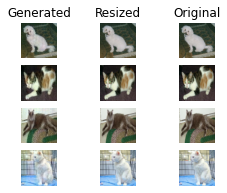

Time for epoch 1 is 21.52367639541626 sec


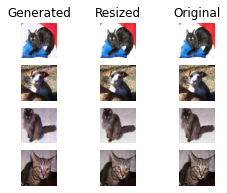

Time for epoch 2 is 19.775969743728638 sec


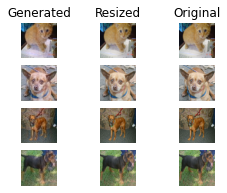

Time for epoch 3 is 19.789395093917847 sec


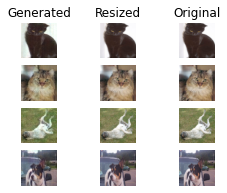

Time for epoch 4 is 19.786690950393677 sec


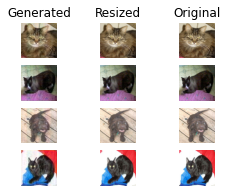

Time for epoch 5 is 19.921701192855835 sec


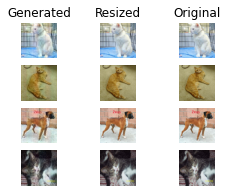

Time for epoch 6 is 19.822442770004272 sec


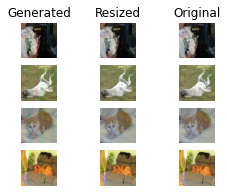

Time for epoch 7 is 19.862191677093506 sec


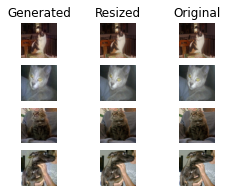

Time for epoch 8 is 19.815425634384155 sec


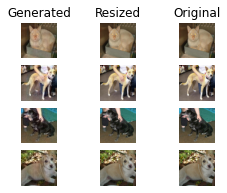

Time for epoch 9 is 19.929423332214355 sec


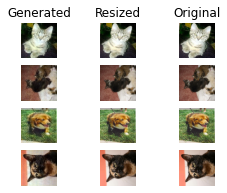

Time for epoch 10 is 19.79824995994568 sec


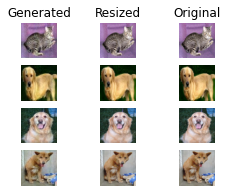

Time for epoch 11 is 19.794533014297485 sec


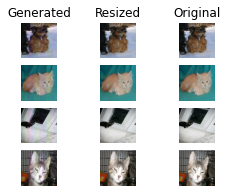

Time for epoch 12 is 19.912851810455322 sec


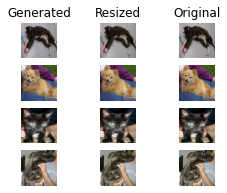

Time for epoch 13 is 19.823533058166504 sec


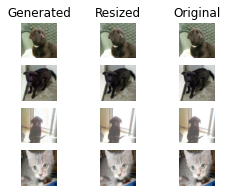

Time for epoch 14 is 19.842397928237915 sec


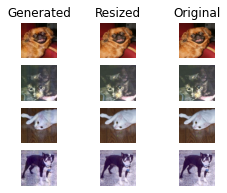

Time for epoch 15 is 19.787076711654663 sec


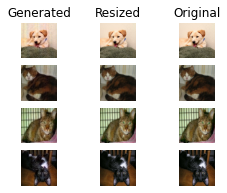

Time for epoch 16 is 19.94496202468872 sec


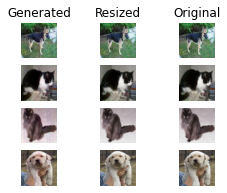

Time for epoch 17 is 19.85709524154663 sec


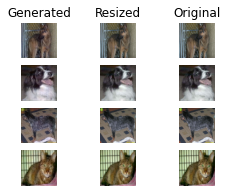

Time for epoch 18 is 19.830717086791992 sec


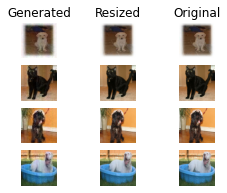

Time for epoch 19 is 19.856003761291504 sec


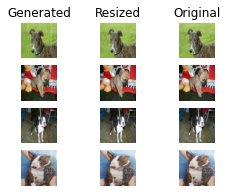

Time for epoch 20 is 19.927441835403442 sec


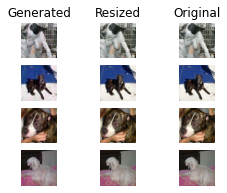

Time for epoch 21 is 19.836856603622437 sec


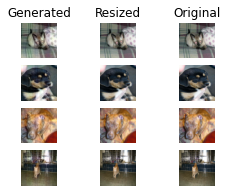

Time for epoch 22 is 19.825663805007935 sec


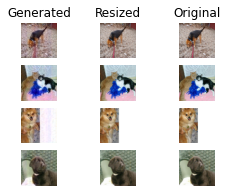

Time for epoch 23 is 19.791553735733032 sec


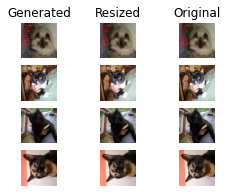

Time for epoch 24 is 19.893251180648804 sec


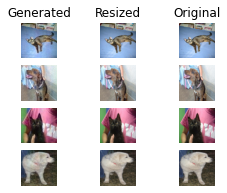

Time for epoch 25 is 19.82431125640869 sec


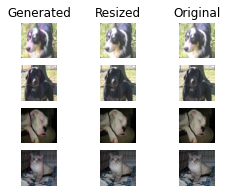

Time for epoch 26 is 19.7806875705719 sec


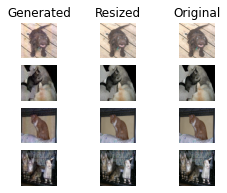

Time for epoch 27 is 19.75846552848816 sec


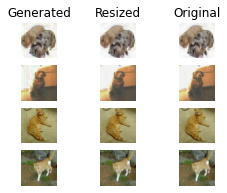

Time for epoch 28 is 19.903870582580566 sec


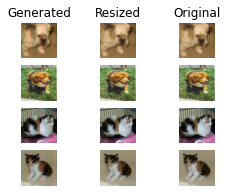

Time for epoch 29 is 19.80002999305725 sec


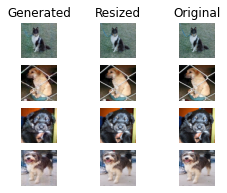

Time for epoch 30 is 19.821349620819092 sec


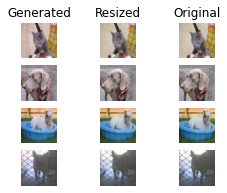

Time for epoch 31 is 20.217812538146973 sec


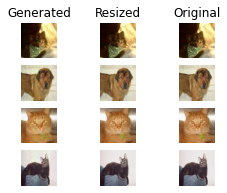

Time for epoch 32 is 20.116088151931763 sec


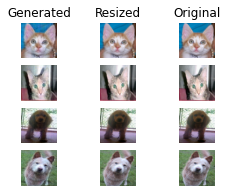

Time for epoch 33 is 19.834341764450073 sec


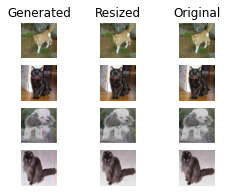

Time for epoch 34 is 19.805623531341553 sec


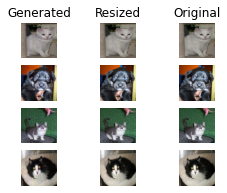

Time for epoch 35 is 19.78770637512207 sec


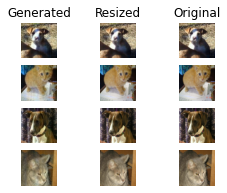

Time for epoch 36 is 19.939090728759766 sec


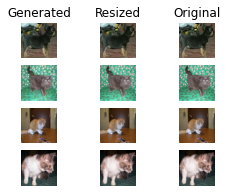

Time for epoch 37 is 19.84113097190857 sec


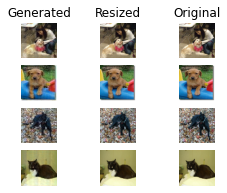

Time for epoch 38 is 19.830840826034546 sec


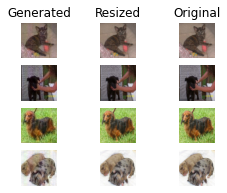

Time for epoch 39 is 19.96380615234375 sec


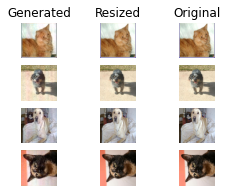

Time for epoch 40 is 19.868847370147705 sec


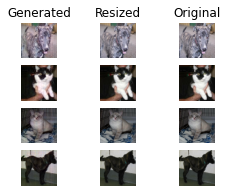

Time for epoch 41 is 20.779584169387817 sec


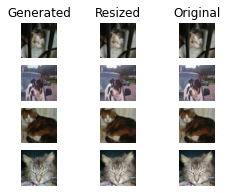

Time for epoch 42 is 21.393971920013428 sec


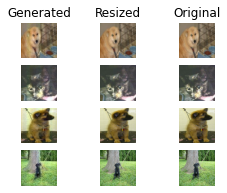

Time for epoch 43 is 20.370481491088867 sec


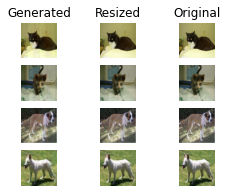

Time for epoch 44 is 20.510472774505615 sec


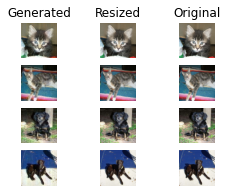

Time for epoch 45 is 20.427440404891968 sec


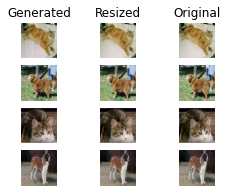

Time for epoch 46 is 19.90452551841736 sec


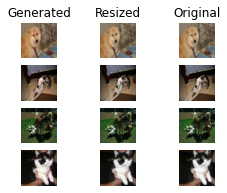

Time for epoch 47 is 19.8828341960907 sec


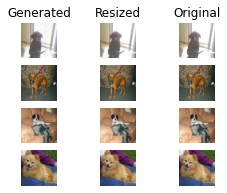

Time for epoch 48 is 20.02696204185486 sec


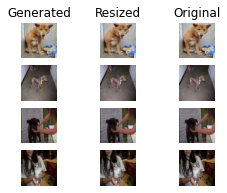

Time for epoch 49 is 20.004651308059692 sec


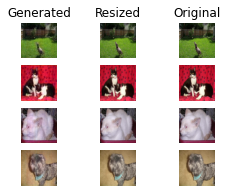

Time for epoch 50 is 19.962963104248047 sec


In [28]:
if train_SRGAN:
    train(train_ds, 50)

In [29]:
if train_SRGAN:
    generator_model.save_weights("models/gen_model.ckpt")
    discriminator_model.save_weights("models/dis_model.ckpt")
else:
    generator_model.load_weights("models/gen_model.ckpt")
    discriminator_model.load_weights("models/dis_model.ckpt")

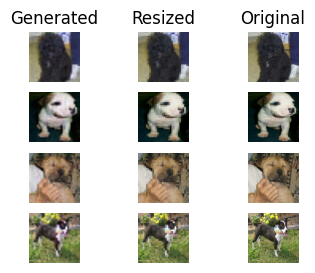

In [20]:
resize_layer = tf.keras.layers.Resizing(128, 128)
iterator = iter(train_ds)
big_dataset = iterator.get_next()
small_dataset = resize_layer(big_dataset)
small_batch = small_batch[0:4]

generate_and_save_images(generator_model, 9999, small_dataset, big_dataset)